In [14]:
from typing import Any
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from pathlib import Path
import json, os, copy
import shutil

class DefineCrossValidation:
    """process:
    cross validation > over/under sampler > train/val split
    fold: [train/val]: [path]
    """

    def __init__(self, video_path, gait_seg_idx_path, K, sampler) -> None:
        self.video_path = Path(video_path)
        self.gait_seg_idx_path = Path(gait_seg_idx_path)
        self.K = K
        self.sampler = sampler

    @staticmethod
    def random_sampler(X: list, y: list, train_idx: list, val_idx: list, sampler):
        # train
        train_mapped_path = []
        new_X_path = [X[i] for i in train_idx]

        sampled_X, sampled_y = sampler.fit_resample(
            [[i] for i in range(len(new_X_path))], [y[i] for i in train_idx]
        )

        # map sampled_X to new_X_path
        for i in sampled_X:
            train_mapped_path.append(new_X_path[i[0]])

        # val
        val_mapped_path = []
        new_X_path = [X[i] for i in val_idx]

        sampled_X, sampled_y = sampler.fit_resample(
            [[i] for i in range(len(new_X_path))], [y[i] for i in val_idx]
        )

        # map
        for i in sampled_X:
            val_mapped_path.append(new_X_path[i[0]])

        return train_mapped_path, val_mapped_path

    @staticmethod
    def process_cross_validation(video_path):
        _path = video_path

        X = []  # patient index
        y = []  # patient class index
        groups = []  # different patient groups
        # process one disease in one loop.
        for disease in _path.iterdir():
            if disease.name != "log":
                patient_list = sorted(list(disease.iterdir()))
                name_map = set()

                for p in patient_list:
                    name, _ = p.name.split("-")
                    name_map.add(name)

                element_to_num = {element: idx for idx, element in enumerate(name_map)}

                for i in range(len(patient_list)):
                    name, _ = patient_list[i].name.split("-")
                    # load the video tensor from json file
                    with open(patient_list[i]) as f:
                        file_info_dict = json.load(f)

                    label = file_info_dict["label"]

                    X.append(patient_list[i])  # true path in Path
                    y.append(label)  # label, 0, 1, 2
                    groups.append(element_to_num[name])  # number of different patient

        return X, y, groups

    def make_val_dataset(self, val_dataset_idx: list, fold: int):
        temp_val_path = self.gait_seg_idx_path / self.sampler / str(fold)
        val_idx = val_dataset_idx

        shutil.rmtree(temp_val_path, ignore_errors=True)

        for path in val_idx:
            with open(path) as f:
                file_info_dict = json.load(f)

            video_name = file_info_dict["video_name"]
            video_path = file_info_dict["video_path"]
            video_disease = file_info_dict["disease"]

            if not (temp_val_path / video_disease).exists():
                (temp_val_path / video_disease).mkdir(parents=True, exist_ok=False)

            shutil.copy(
                video_path, temp_val_path / video_disease / (video_name + ".mp4")
            )

        return temp_val_path

    def prepare(self):
        """define cross validation first, with the K.
        #! the 1 fold and K fold should return the same format.
        fold: [train/val]: [path]

        Args:
            video_path (str): the index of the video path, in .json format.
            K (int, optional): crossed number of validation. Defaults to 5, can be 1 or K.

        Returns:
            list: the format like upper.
        """
        K = self.K

        ans_fold = {}

        # define the cross validation
        X, y, groups = self.process_cross_validation(self.video_path)

        sgkf = StratifiedGroupKFold(n_splits=K)

        for i, (train_index, test_index) in enumerate(
            sgkf.split(X=X, y=y, groups=groups)
        ):
            if self.sampler in ["over", "under"]:
                if self.sampler == "over":
                    ros = RandomOverSampler(random_state=42)
                elif self.sampler == "under":
                    ros = RandomUnderSampler(random_state=42)

                train_mapped_path, val_mapped_path = self.random_sampler(
                    X, y, train_index, test_index, ros
                )

            else:
                train_mapped_path = [X[i] for i in train_index]
                val_mapped_path = [X[i] for i in test_index]

            # make the val data path
            val_mapped_path = self.make_val_dataset(val_mapped_path, i)

            ans_fold[i] = [train_mapped_path, val_mapped_path]

        return ans_fold, X, y, groups

    def __call__(self, *args: Any, **kwds: Any) -> Any:

        if not os.path.exists(self.gait_seg_idx_path/ self.sampler):
            fold_dataset_idx, *_ = self.prepare()

            json_fold_dataset_idx = copy.deepcopy(fold_dataset_idx)

            for k, v in fold_dataset_idx.items():
                
                # train
                train_dataset_idx = v[0]

                json_fold_dataset_idx[k][0] = [str(i) for i in train_dataset_idx]

                # val
                val_dataset_idx = v[1]
                json_fold_dataset_idx[k][1] = str(val_dataset_idx)

            with open((self.gait_seg_idx_path / self.sampler / "index.json"), "w") as f:
                json.dump(json_fold_dataset_idx, f)


        elif os.path.exists(self.gait_seg_idx_path):
            with open(self.gait_seg_idx_path / self.sampler / "index.json", "r") as f:
                fold_dataset_idx = json.load(f)

            for k, v in fold_dataset_idx.items():
                # train
                train_dataset_idx = v[0]
                fold_dataset_idx[k][0] = [Path(i) for i in train_dataset_idx]

                # val
                val_dataset_idx = v[1]
                fold_dataset_idx[k][1] = Path(val_dataset_idx)
                
        else:
            raise ValueError(
                "the gait seg idx path is not exist, please check the path."
            )

        return fold_dataset_idx

video_path = "/workspace/data/segmentation_dataset_512/json"
gait_seg_idx_path = "/workspace/data/gait_seg_index_dataset_512/"
sampler = "none"
fold_dict = DefineCrossValidation(video_path, gait_seg_idx_path, K=3, sampler=sampler)()

In [1]:
import json
# load from json file 
over_path = "/workspace/data/gait_seg_index_dataset_512/under/index.json"
with open(over_path) as f:
    file_info_dict = json.load(f)

# convert str to Path 
from pathlib import Path
for key, value in file_info_dict.items():
    file_info_dict[key][0] = [Path(i) for i in value[0]]
    file_info_dict[key][1] = Path(value[1])

fold_dict = file_info_dict

# Draw the histogram of the data

In [2]:
# fold:train/val:disease:idx

CLASS = ["ASD", "DHS", "LCS_HipOA"]
NAME = ["ASD", "DHS", "LCS", "HipOA"]


# ! 有个问题，每个人的视频切片数量是不一样的，这个时候容易造成数据不平衡啊。
# ！不过先忽略这个问题吧，就按照人的数量来分。因为之前的研究也没有考到到细小样本不平衡的问题。
for fold, train_val in fold_dict.items():
    
    train_dict = {n:[] for n in CLASS}
    val_dict = {n:[] for n in CLASS}

    train_idx, val_idx = train_val
    
    # train 
    for i in train_idx:
        for n in NAME:
            if n in i.name:
                try:
                    train_dict[n].append(i)
                except:
                    train_dict['LCS_HipOA'].append(i)

    # val   
    for disease in Path(val_idx).iterdir():
        val_dis_len = len(list(disease.iterdir()))


    for disease, v in train_dict.items():
        print(f"train:{fold}, {disease}, {len(v)}")
        print(f"val:{fold}, {disease}, {val_dis_len}")

    print("#"*20)

train:0, ASD, 230
val:0, ASD, 94
train:0, DHS, 230
val:0, DHS, 94
train:0, LCS_HipOA, 230
val:0, LCS_HipOA, 94
####################
train:1, ASD, 210
val:1, ASD, 114
train:1, DHS, 210
val:1, DHS, 114
train:1, LCS_HipOA, 210
val:1, LCS_HipOA, 114
####################
train:2, ASD, 208
val:2, ASD, 116
train:2, DHS, 208
val:2, DHS, 116
train:2, LCS_HipOA, 208
val:2, LCS_HipOA, 116
####################


In [2]:
import torch 


# Need to draw the data distribution of the dataset

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the class/group data
n_points = 100

cmap_data = plt.cm.Paired

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

NameError: name 'y' is not defined

In [22]:
uid_y = y.copy()
uid_groups = groups.copy()

for index, i in enumerate(set(uid_groups)):
    for num, j in enumerate(uid_groups):
        if i == j:
            uid_groups[num] = index

for index, i in enumerate(set(uid_y)):
    for num, j in enumerate(uid_y):
        if i == j:
            uid_y[num] = index

<Axes: title={'center': 'StratifiedGroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

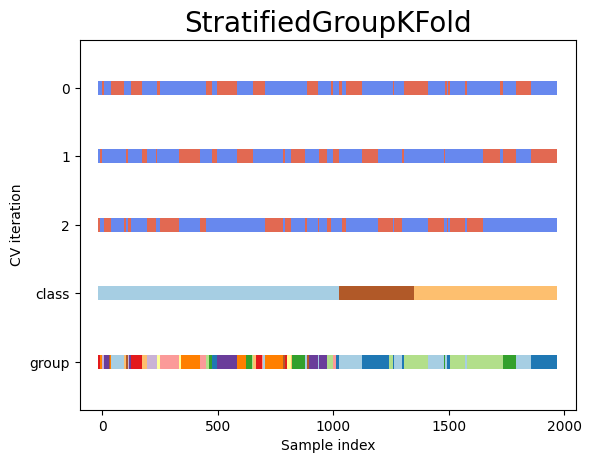

In [23]:
import numpy as np 
cmap_cv = plt.cm.coolwarm
cmap_data = plt.cm.Paired

def plot_cv_indices(cv, X, y, group, ax:plt, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        # xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=20)

    return ax

fig, ax = plt.subplots()
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
sgkf = StratifiedGroupKFold(n_splits=3)
plot_cv_indices(sgkf, X, uid_y, uid_groups, ax, 3)

# Dataset balance

In [132]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 RandomUnderSampler 进行欠采样
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)



ValueError: Expected 2D array, got 1D array instead:
array=[PosixPath('/workspace/data/segmentation_dataset_512/json/ASD/20160120_ASD_lat__V1-0001.json')
 PosixPath('/workspace/data/segmentation_dataset_512/json/ASD/20160120_ASD_lat__V1-0002.json')
 PosixPath('/workspace/data/segmentation_dataset_512/json/ASD/20160120_ASD_lat__V1-0003.json')
 ...
 PosixPath('/workspace/data/segmentation_dataset_512/json/DHS/20210812_DHS_lat_V1-0038.json')
 PosixPath('/workspace/data/segmentation_dataset_512/json/DHS/20210812_DHS_lat_V1-0039.json')
 PosixPath('/workspace/data/segmentation_dataset_512/json/DHS/20210812_DHS_lat_V1-0040.json')].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [152]:
X_index = [[i] for i in range(len(X))]

In [153]:
from imblearn.over_sampling import RandomOverSampler

smote = RandomOverSampler(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_index, y)

In [23]:
new_list = []
for i in X_resampled:
    new_list.append(X[i[0]])

NameError: name 'X_resampled' is not defined